# Daily Sunshine App NLP Model

## Objective of this Notebook
To create a NLP Model that classifies a given piece of plaintext into two categories, Good or Bad. The output of the model will be presented as a floating point numeral. This numeral will help us interpret the decision.

## Notebook Plan

- Multiple models will be created for each of the following datasets as training input
  - [IMDb Movie Reviews Dataset](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)
  - [Financial Phrase Bank Dataset](https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news)
  - [Positive and Negative Word List](https://www.kaggle.com/datasets/mukulkirti/positive-and-negative-word-listrar)
  - [News Sentiment Dataset](https://www.kaggle.com/datasets/hoshi7/news-sentiment-dataset)

- All the above models will be tested on 
  - New Data points from the newsapi.org API
  - ["All the News" Dataset](https://www.kaggle.com/datasets/snapcrack/all-the-news)
  - ["Million News Headlines" Dataset](https://www.kaggle.com/datasets/therohk/million-headlines)
  

## Notebook Instructions

This notebook contains all necessary code to import a LLM model, train it, make predictions and export it for further inference.

Along with the creation of usable models, it also contains a script to utilize the previously exported models and make predictions of newly fetched data from the [NewsAPI.org](https://newsapi.org/docs/endpoints) endpoints. This code is a demonstrative script and it is put to use in Firebase Cloud Functions.

---

Any of the following actions may be desired based on your scenario of usage -

- **Train the models from scratch using your own dataset(s)**
- **Understand and visualise the training data, script, evaluation methods** 
- **Visualize the evaluation metrics such as Accuracy, Loss, etc**
- **Save and/or Export models for future**

**In any of the above cases, consider executing the notebook only upto the Section ["Save All Models for later user"](#scrollTo=Save_All_Models_for_later_use)**

---

**If you have trained or copied the required models, you may skip the sections prior to ["Load Previously Built Models"](#scrollTo=Load_Previously_Built_Models)**


#### **NOTE: Under all scenarios, you must run the ["Pre Requisites"](#scrollTo=Pre_Requisites) section.**


## Pre-Requisites

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.12.*"
!pip install -q tf-models-official==2.12.0

In [2]:
import os
import shutil

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Training Pre-Requisites

In [ ]:
def build_classifier_model(preprocess, encoder):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

## Evaluation Datasets

### "All the News" Dataset

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/all_the_news.csv" "/content/all_the_news.csv"

In [ ]:
atn_dataframe = pd.read_csv('all_the_news.csv', encoding = 'utf-8', encoding_errors = 'ignore')

In [ ]:
atn_dataframe.drop(atn_dataframe.iloc[:, 3:], inplace=True, axis=1)
atn_dataframe.drop(atn_dataframe.iloc[:, :2], inplace=True, axis=1)
atn_dataframe

,title
0,House Republicans Fret About Winning Their Hea...
1,Rift Between Officers and Residents as Killing...
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ..."
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi..."
4,Kim Jong-un Says North Korea Is Preparing to T...
...,...
49995,"Rex Tillerson Says Climate Change Is Real, but …"
49996,The Biggest Intelligence Questions Raised by t...
49997,Trump Announces Plan That Does Little to Resol...
49998,Dozens of For-Profit Colleges Could Soon Close


In [ ]:
def atn_array(n = 10):
  return np.squeeze(atn_dataframe.sample(n=n).values)

In [ ]:
atn_array(20)

array(['Fed Indictments Target Alleged Italian Mob Family in NYC',
       'Baltimore unrest as Obama pushes mentoring program',
       'First Time Ever All Refugee Olympic Team Heading to Summer Games - Breitbart',
       'White House gears up for prolonged Russia fight',
       'Natalee Holloway’s father opens up about new lead',
       'Fact-Checking Apple’s Claims on E.U. Tax Ruling - The New York Times',
       'Always moving: A transient way of life',
       'Italy Struggles To House Migrants In Third Year Of Mass Arrivals',
       'Federer vs. Nadal: Which way will it go? ',
       'The owner of the convenience store where Alton Sterling was killed is suing the police',
       'Five U.S. Women’s Soccer Teammates File Discrimination Suit Against U.S. Soccer - Breitbart',
       'What would happen if you experienced Trump’s brag? ',
       'Betty White: ’I am the luckiest old broad on two feet’',
       '7 shot at Florida house party',
       'Country Duo Big &amp Rich to Perform a

### Million News Headlines Dataset

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/million_news_headlines.csv" "/content/million_news_headlines.csv"

In [ ]:
mnh_dataframe = pd.read_csv('million_news_headlines.csv', encoding = 'utf-8', encoding_errors = 'ignore')
mnh_dataframe

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


In [ ]:
mnh_dataframe.drop(mnh_dataframe.iloc[:, 0:1], inplace=True, axis=1)
mnh_dataframe

,headline_text
0,aba decides against community broadcasting lic...
1,act fire witnesses must be aware of defamation
2,a g calls for infrastructure protection summit
3,air nz staff in aust strike for pay rise
4,air nz strike to affect australian travellers
...,...
1244179,two aged care residents die as state records 2...
1244180,victoria records 5;919 new cases and seven deaths
1244181,wa delays adopting new close contact definition
1244182,western ringtail possums found badly dehydrate...


In [ ]:
def mnh_array(n = 10):
  return np.squeeze(mnh_dataframe.sample(n=n).values)

In [ ]:
mnh_array(20)

array(['sinking navy ships will be a loss to history',
       'iemma confirms kurnell desalination plant planning',
       '911 rescue dog cloned', 'ramos horta denies aust interference',
       '50th anniversary of the royal australian navy helicopter flight',
       'warm november for south west wa',
       'family had lucky escape from glemorchy house fire',
       'interview with mark vassella',
       'bennett calls for fair trade period',
       'south west national park continues to burn',
       'joyce opposes sick leave rules',
       'police investigate mandurah ram raid',
       'pole protester brought down', 'all ords breaks through 4000 mark',
       'woman goes missing near bombala',
       'nsw opposition accuses govt of delaying tunnel',
       'forestry practices in tasmania recognised in',
       'sonya lovell and her daughter bronwyn run the que',
       'federal fallout is bad news for keneally',
       'rta figures back call for highway road dividers'], dtype=objec

In [ ]:
# Fixed Dataset for comparing models

eval_data = np.concatenate([atn_array(100), mnh_array(100)], 0)

## Model I - IMDb Movie Review Dataset

### Downloading the Dataset

In [ ]:
imdb_url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

imdb_dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', imdb_url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

imdb_dataset_dir = os.path.join(os.path.dirname(imdb_dataset), 'aclImdb')

imdb_train_dir = os.path.join(imdb_dataset_dir, 'train')

84125825/84125825 [==============================] - 8s 0us/step


In [ ]:
# Remove unused folders to make it easier to load the data
imdb_remove_dir = os.path.join(imdb_train_dir, 'unsup')
shutil.rmtree(imdb_remove_dir)

### Split the Data into Training, Testing & Validation sets

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

imdb_raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

imdb_class_names = imdb_raw_train_ds.class_names
imdb_train_ds = imdb_raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

imdb_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

imdb_val_ds = imdb_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

imdb_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

imdb_test_ds = imdb_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### Visualise the data

In [ ]:
for text_batch, label_batch in imdb_train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({imdb_class_names[label]})\n')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)

Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as the

### Selecting a Model

In [ ]:
#@title Choose a BERT model to fine-tune for IMDb Model

imdb_bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]


imdb_tfhub_handle_encoder = map_name_to_handle[imdb_bert_model_name]
imdb_tfhub_handle_preprocess = map_model_to_preprocess[imdb_bert_model_name]

print(f'BERT model selected           : {imdb_tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {imdb_tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Preprocessing Model

In [ ]:
imdb_bert_preprocess_model = hub.KerasLayer(imdb_tfhub_handle_preprocess)

### Using the BERT Model

In [ ]:
imdb_bert_model = hub.KerasLayer(imdb_tfhub_handle_encoder)

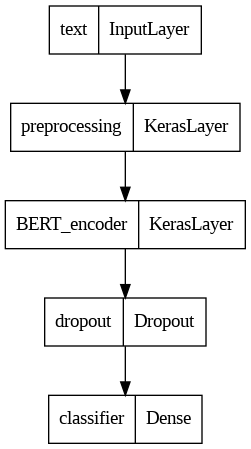

In [ ]:
imdb_classifier_model = build_classifier_model(imdb_tfhub_handle_preprocess, imdb_tfhub_handle_encoder)
tf.keras.utils.plot_model(imdb_classifier_model)

In [ ]:
imdb_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
imdb_metrics = tf.metrics.BinaryAccuracy()

imdb_epochs = 5
imdb_steps_per_epoch = tf.data.experimental.cardinality(imdb_train_ds).numpy()
imdb_num_train_steps = imdb_steps_per_epoch * imdb_epochs
imdb_num_warmup_steps = int(0.1*imdb_num_train_steps)

imdb_init_lr = 3e-5
imdb_optimizer = optimization.create_optimizer(init_lr=imdb_init_lr,
                                          num_train_steps=imdb_num_train_steps,
                                          num_warmup_steps=imdb_num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
imdb_classifier_model.compile(optimizer=imdb_optimizer,
                         loss=imdb_loss,
                         metrics=imdb_metrics)

imdb_history = imdb_classifier_model.fit(x=imdb_train_ds,
                               validation_data=imdb_val_ds,
                               epochs=imdb_epochs)

Epoch 1/5
625/625 [==============================] - 189s 288ms/step - loss: 0.4930 - binary_accuracy: 0.7370 - val_loss: 0.3929 - val_binary_accuracy: 0.8326
Epoch 2/5
625/625 [==============================] - 179s 286ms/step - loss: 0.3310 - binary_accuracy: 0.8501 - val_loss: 0.3713 - val_binary_accuracy: 0.8484
Epoch 3/5
625/625 [==============================] - 178s 285ms/step - loss: 0.2531 - binary_accuracy: 0.8929 - val_loss: 0.3965 - val_binary_accuracy: 0.8432
Epoch 4/5
625/625 [==============================] - 178s 285ms/step - loss: 0.1965 - binary_accuracy: 0.9213 - val_loss: 0.4444 - val_binary_accuracy: 0.8518
Epoch 5/5
625/625 [==============================] - 178s 285ms/step - loss: 0.1499 - binary_accuracy: 0.9433 - val_loss: 0.4825 - val_binary_accuracy: 0.8516


### Evaluating the Model

In [ ]:
imdb_loss, imdb_accuracy = imdb_classifier_model.evaluate(imdb_test_ds)

print(f'Loss: {imdb_loss}')
print(f'Accuracy: {imdb_accuracy}')

782/782 [==============================] - 104s 133ms/step - loss: 0.4678 - binary_accuracy: 0.8537
Loss: 0.4678176939487457
Accuracy: 0.8536800146102905


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


Text(0, 0.5, 'Accuracy')

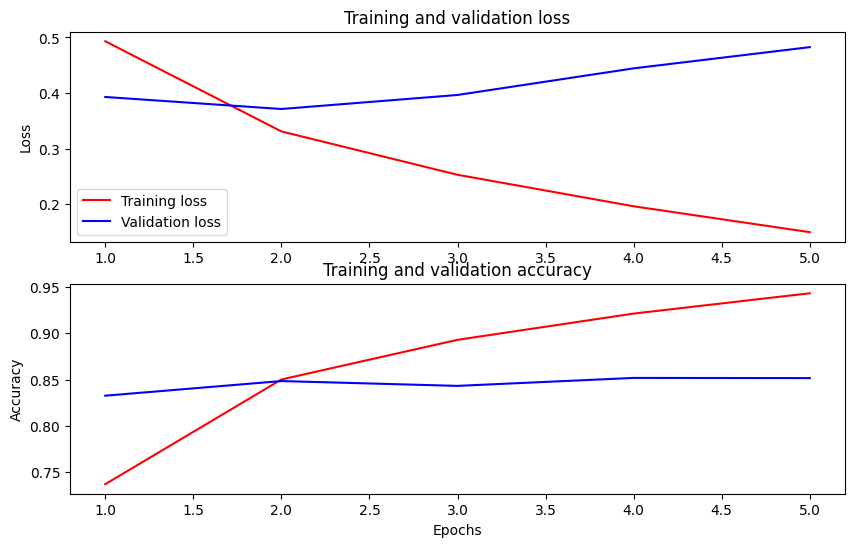

In [ ]:
imdb_history_dict = imdb_history.history
print(imdb_history_dict.keys())

imdb_acc = imdb_history_dict['binary_accuracy']
imdb_val_acc = imdb_history_dict['val_binary_accuracy']
imdb_loss = imdb_history_dict['loss']
imdb_val_loss = imdb_history_dict['val_loss']

imdb_epochs = range(1, len(imdb_acc) + 1)
imdb_fig = plt.figure(figsize=(10, 6))
imdb_fig.tight_layout()

plt.subplot(2, 1, 1)

plt.plot(imdb_epochs, imdb_loss, 'r', label='Training loss')

plt.plot(imdb_epochs, imdb_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(imdb_epochs, imdb_acc, 'r', label='Training acc')
plt.plot(imdb_epochs, imdb_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Make Predictions

In [ ]:
# imdb_eval_data = np.concatenate([atn_array(30), mnh_array(30)], 0)
imdb_df = pd.DataFrame(np.squeeze(imdb_classifier_model.predict(eval_data)))
imdb_df.insert(1, "Title", eval_data, True)
imdb_df

7/7 [==============================] - 1s 86ms/step


,0,Title
0,-0.733837,Girl Scouts refuse gift with transgender limits
1,1.946372,American to launch Dreamliner 787 service
2,-0.163686,15 Times Celebrities Envisioned Violence Again...
3,0.435629,Deadly Northern California Wildfire Spreads - ...
4,2.373650,How Millennials Became Spooked by Credit Cards...
...,...,...
195,3.655803,moutiaa el zahed gives the islamic state salute
196,-0.399266,afp defends raiding abc office annika smethurs...
197,2.530798,interview david williams
198,3.797237,top sprint cyclists put through paces ahead of...


## Model II - Financial Phrase Bank Dataset

### Downloading the Dataset

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/financial_phrase_bank.csv" "/content/financial_phrase_bank.csv"

In [ ]:
fpb_dataframe = pd.read_csv('financial_phrase_bank.csv', encoding = 'utf-8', encoding_errors = 'ignore', names = ('Tone', 'Headline'))
fpb_dataframe = fpb_dataframe[fpb_dataframe['Tone'] != 'neutral']
fpb_dataframe

,Tone,Headline
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,positive,"For the last quarter of 2010 , Componenta 's n..."
...,...,...
4840,negative,HELSINKI Thomson Financial - Shares in Cargote...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


### Split the Data into Trinaing, Testing and Validation sets

In [ ]:
!rm -rf financial_phrase_bank

In [ ]:
fpb_dataset_dir = 'financial_phrase_bank'

os.mkdir(fpb_dataset_dir)

fpb_train_dir = os.path.join(fpb_dataset_dir, 'train')
fpb_test_dir = os.path.join(fpb_dataset_dir, 'test')

os.mkdir(fpb_train_dir)
os.mkdir(fpb_test_dir)

for path in [fpb_train_dir, fpb_test_dir]:
  os.mkdir(os.path.join(path, 'negative'))
  os.mkdir(os.path.join(path, 'positive'))


count_train = 1
count_test = 1

# Training Dataset
for ind in fpb_dataframe[int(.7*len(fpb_dataframe)):].index:
  with open(os.path.join(fpb_train_dir,  fpb_dataframe['Tone'][ind], str(count_train)+'.txt'), 'w') as file_obj:
    file_obj.write(fpb_dataframe['Headline'][ind])
  count_train +=1

# Testing Dataset
for ind in fpb_dataframe[:int(.3*len(fpb_dataframe))].index:
  with open(os.path.join(fpb_test_dir,  fpb_dataframe['Tone'][ind], str(count_test)+'.txt'), 'w') as file_obj:
    file_obj.write(fpb_dataframe['Headline'][ind])
  count_test +=1

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

fpb_raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    fpb_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

fpb_class_names = fpb_raw_train_ds.class_names
fpb_train_ds = fpb_raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

fpb_val_ds = tf.keras.utils.text_dataset_from_directory(
    fpb_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

fpb_val_ds = fpb_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

fpb_test_ds = tf.keras.utils.text_dataset_from_directory(
    fpb_test_dir,
    batch_size=batch_size)

fpb_test_ds = fpb_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 591 files belonging to 2 classes.
Using 473 files for training.
Found 591 files belonging to 2 classes.
Using 118 files for validation.
Found 590 files belonging to 2 classes.


### Selecting a Model

In [ ]:
#@title Choose a BERT model to fine-tune for Financial Phrase Bank Model

fpb_bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]


fpb_tfhub_handle_encoder = map_name_to_handle[fpb_bert_model_name]
fpb_tfhub_handle_preprocess = map_model_to_preprocess[fpb_bert_model_name]

print(f'BERT model selected           : {fpb_tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {fpb_tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Using the BERT Model

In [ ]:
fpb_bert_preprocess_model = hub.KerasLayer(fpb_tfhub_handle_preprocess)

In [ ]:
fpb_bert_model = hub.KerasLayer(fpb_tfhub_handle_encoder)

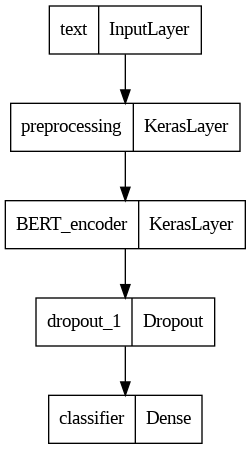

In [ ]:
fpb_classifier_model = build_classifier_model(fpb_tfhub_handle_preprocess, fpb_tfhub_handle_encoder)
tf.keras.utils.plot_model(fpb_classifier_model)

In [ ]:
fpb_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
fpb_metrics = tf.metrics.BinaryAccuracy()

fpb_epochs = 10
fpb_steps_per_epoch = tf.data.experimental.cardinality(fpb_train_ds).numpy()
fpb_num_train_steps = fpb_steps_per_epoch * fpb_epochs
fpb_num_warmup_steps = int(0.1*fpb_num_train_steps)

fpb_init_lr = 3e-5
fpb_optimizer = optimization.create_optimizer(init_lr=fpb_init_lr,
                                          num_train_steps=fpb_num_train_steps,
                                          num_warmup_steps=fpb_num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
fpb_classifier_model.compile(optimizer=fpb_optimizer,
                         loss=fpb_loss,
                         metrics=fpb_metrics)

fpb_history = fpb_classifier_model.fit(x=fpb_train_ds,
                               validation_data=fpb_val_ds,
                               epochs=fpb_epochs)

Epoch 1/10
15/15 [==============================] - 20s 456ms/step - loss: 0.4517 - binary_accuracy: 0.8372 - val_loss: 0.2721 - val_binary_accuracy: 0.8814
Epoch 2/10
15/15 [==============================] - 7s 462ms/step - loss: 0.3059 - binary_accuracy: 0.8774 - val_loss: 0.2127 - val_binary_accuracy: 0.9407
Epoch 3/10
15/15 [==============================] - 6s 407ms/step - loss: 0.1871 - binary_accuracy: 0.9281 - val_loss: 0.1902 - val_binary_accuracy: 0.9492
Epoch 4/10
15/15 [==============================] - 7s 452ms/step - loss: 0.1227 - binary_accuracy: 0.9471 - val_loss: 0.1612 - val_binary_accuracy: 0.9661
Epoch 5/10
15/15 [==============================] - 6s 411ms/step - loss: 0.0733 - binary_accuracy: 0.9641 - val_loss: 0.1761 - val_binary_accuracy: 0.9576
Epoch 6/10
15/15 [==============================] - 7s 459ms/step - loss: 0.0380 - binary_accuracy: 0.9810 - val_loss: 0.1670 - val_binary_accuracy: 0.9576
Epoch 7/10
15/15 [==============================] - 6s 407ms/st

### Evaluate the Model

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


Text(0, 0.5, 'Accuracy')

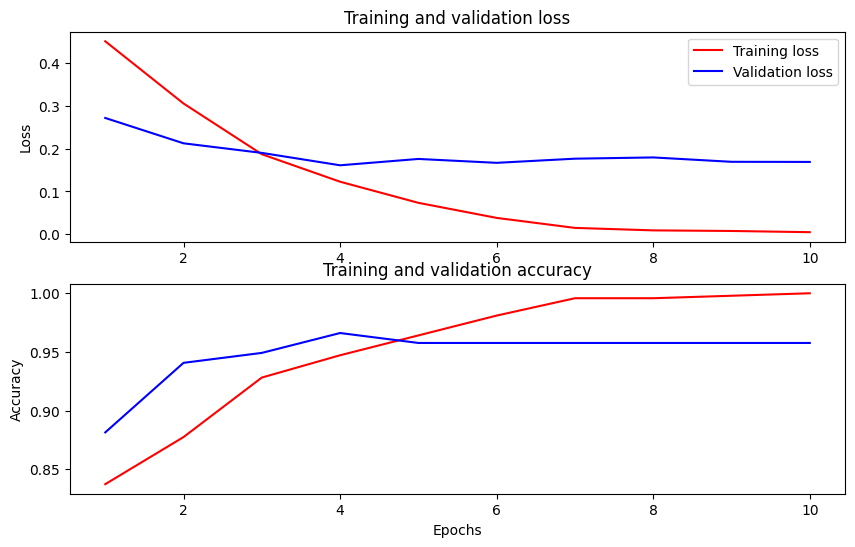

In [ ]:
fpb_history_dict = fpb_history.history
print(fpb_history_dict.keys())

fpb_acc = fpb_history_dict['binary_accuracy']
fpb_val_acc = fpb_history_dict['val_binary_accuracy']
fpb_loss = fpb_history_dict['loss']
fpb_val_loss = fpb_history_dict['val_loss']

fpb_epochs = range(1, len(fpb_acc) + 1)
fpb_fig = plt.figure(figsize=(10, 6))
fpb_fig.tight_layout()

plt.subplot(2, 1, 1)

plt.plot(fpb_epochs, fpb_loss, 'r', label='Training loss')

plt.plot(fpb_epochs, fpb_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(fpb_epochs, fpb_acc, 'r', label='Training acc')
plt.plot(fpb_epochs, fpb_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Make Predictions

In [ ]:
# fpb_eval_data = np.concatenate([atn_array(100), mnh_array(100)], 0)
fpb_df = pd.DataFrame(np.squeeze(fpb_classifier_model.predict(eval_data)), columns=['FPB Model'])
fpb_df.insert(1, "Title", eval_data, True)
fpb_df

7/7 [==============================] - 2s 140ms/step


,FPB Model,Title
0,-5.805300,Girl Scouts refuse gift with transgender limits
1,4.798319,American to launch Dreamliner 787 service
2,-4.357934,15 Times Celebrities Envisioned Violence Again...
3,-3.547501,Deadly Northern California Wildfire Spreads - ...
4,-3.737055,How Millennials Became Spooked by Credit Cards...
...,...,...
195,0.817480,moutiaa el zahed gives the islamic state salute
196,-4.373072,afp defends raiding abc office annika smethurs...
197,0.933000,interview david williams
198,1.491438,top sprint cyclists put through paces ahead of...


### Compare Predictions with the IMDb Model

In [ ]:
overall_df = fpb_df
overall_df.insert(0, "IMDb Model", imdb_df[0])
overall_df

,IMDb Model,FPB Model,Title
0,-0.733837,-5.805300,Girl Scouts refuse gift with transgender limits
1,1.946372,4.798319,American to launch Dreamliner 787 service
2,-0.163686,-4.357934,15 Times Celebrities Envisioned Violence Again...
3,0.435629,-3.547501,Deadly Northern California Wildfire Spreads - ...
4,2.373650,-3.737055,How Millennials Became Spooked by Credit Cards...
...,...,...,...
195,3.655803,0.817480,moutiaa el zahed gives the islamic state salute
196,-0.399266,-4.373072,afp defends raiding abc office annika smethurs...
197,2.530798,0.933000,interview david williams
198,3.797237,1.491438,top sprint cyclists put through paces ahead of...


## Model III - Positive and Negative Word List Dataset

### Downloading the Dataset

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/positive_and_negative_word_list.csv" "/content/positive_and_negative_word_list.csv"

In [ ]:
pnw_dataframe = pd.read_csv('positive_and_negative_word_list.csv', encoding = 'utf-8', encoding_errors = 'ignore', names = ('Negative', 'Positive'))
pnw_dataframe

,Negative,Positive
1,abnormal,able
2,abolish,abundance
3,abominable,accelerate
4,abominably,accept
5,abominate,acclaim
...,...,...
4716,zenana,NaN
4717,zephyr,NaN
4718,zero,NaN
4719,zol,NaN


### Split the data into Training, Testing and Validation Datasets

In [ ]:
!rm -rf positive_and_negative_word_list

In [ ]:
pnw_dataset_dir = 'positive_and_negative_word_list'

os.mkdir(pnw_dataset_dir)

pnw_train_dir = os.path.join(pnw_dataset_dir, 'train')
pnw_test_dir = os.path.join(pnw_dataset_dir, 'test')

os.mkdir(pnw_train_dir)
os.mkdir(pnw_test_dir)

for path in [pnw_train_dir, pnw_test_dir]:
  os.mkdir(os.path.join(path, 'negative'))
  os.mkdir(os.path.join(path, 'positive'))


count_train = 1
count_test = 1

# Training Dataset
for ind in pnw_dataframe[int(.6*len(pnw_dataframe)):].index:
  with open(os.path.join(pnw_train_dir,  'negative', str(count_train)+'.txt'), 'w') as file_obj:
    file_obj.write(pnw_dataframe['Negative'][ind])
  count_train +=1
  with open(os.path.join(pnw_train_dir,  'positive', str(count_train)+'.txt'), 'w') as file_obj:
    if (isinstance(pnw_dataframe['Positive'][ind], str)):
      file_obj.write(pnw_dataframe['Positive'][ind])
      count_train += 1

# Testing Dataset
for ind in pnw_dataframe[:int(.3*len(pnw_dataframe))].index:
  with open(os.path.join(pnw_test_dir,  'negative', str(count_test)+'.txt'), 'w') as file_obj:
    file_obj.write(pnw_dataframe['Negative'][ind])
  count_test +=1
  with open(os.path.join(pnw_test_dir,  'positive', str(count_test)+'.txt'), 'w') as file_obj:
    if (isinstance(pnw_dataframe['Positive'][ind], str)):
      file_obj.write(pnw_dataframe['Positive'][ind])
      count_test += 1

### Preprocess Data

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

pnw_raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    pnw_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

pnw_class_names = pnw_raw_train_ds.class_names
pnw_train_ds = pnw_raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

pnw_val_ds = tf.keras.utils.text_dataset_from_directory(
    pnw_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

pnw_val_ds = pnw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

pnw_test_ds = tf.keras.utils.text_dataset_from_directory(
    pnw_test_dir,
    batch_size=batch_size)

pnw_test_ds = pnw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3776 files belonging to 2 classes.
Using 3021 files for training.
Found 3776 files belonging to 2 classes.
Using 755 files for validation.
Found 2832 files belonging to 2 classes.


### Selecting a BERT Model

In [ ]:
#@title Choose a BERT model to fine-tune for Positive and Negative Word List Model

pnw_bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]


pnw_tfhub_handle_encoder = map_name_to_handle[pnw_bert_model_name]
pnw_tfhub_handle_preprocess = map_model_to_preprocess[pnw_bert_model_name]

print(f'BERT model selected           : {pnw_tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {pnw_tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3


In [ ]:
pnw_bert_preprocess_model = hub.KerasLayer(pnw_tfhub_handle_preprocess)

In [ ]:
pnw_bert_model = hub.KerasLayer(pnw_tfhub_handle_encoder)

### Using the BERT Model

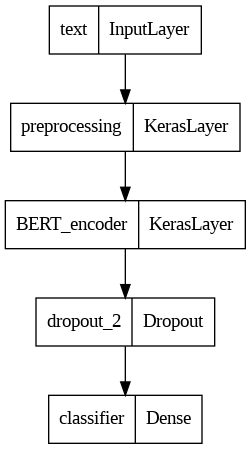

In [ ]:
pnw_classifier_model = build_classifier_model(pnw_tfhub_handle_preprocess, pnw_tfhub_handle_encoder)
tf.keras.utils.plot_model(pnw_classifier_model)

In [ ]:
pnw_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
pnw_metrics = tf.metrics.BinaryAccuracy()

pnw_epochs = 10
pnw_steps_per_epoch = tf.data.experimental.cardinality(pnw_train_ds).numpy()
pnw_num_train_steps = pnw_steps_per_epoch * pnw_epochs
pnw_num_warmup_steps = int(0.1*pnw_num_train_steps)

pnw_init_lr = 3e-5
pnw_optimizer = optimization.create_optimizer(init_lr=pnw_init_lr,
                                          num_train_steps=pnw_num_train_steps,
                                          num_warmup_steps=pnw_num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
pnw_classifier_model.compile(optimizer=pnw_optimizer,
                         loss=pnw_loss,
                         metrics=pnw_metrics)

pnw_history = pnw_classifier_model.fit(x=pnw_train_ds,
                               validation_data=pnw_val_ds,
                               epochs=pnw_epochs)

Epoch 1/10
95/95 [==============================] - 123s 1s/step - loss: 0.6235 - binary_accuracy: 0.6064 - val_loss: 0.4575 - val_binary_accuracy: 0.7682
Epoch 2/10
95/95 [==============================] - 103s 1s/step - loss: 0.4003 - binary_accuracy: 0.8113 - val_loss: 0.6714 - val_binary_accuracy: 0.7695
Epoch 3/10
95/95 [==============================] - 101s 1s/step - loss: 0.2796 - binary_accuracy: 0.8838 - val_loss: 0.7599 - val_binary_accuracy: 0.8013
Epoch 4/10
95/95 [==============================] - 101s 1s/step - loss: 0.2136 - binary_accuracy: 0.9172 - val_loss: 0.5726 - val_binary_accuracy: 0.8384
Epoch 5/10
95/95 [==============================] - 100s 1s/step - loss: 0.1737 - binary_accuracy: 0.9318 - val_loss: 0.8703 - val_binary_accuracy: 0.8132
Epoch 6/10
95/95 [==============================] - 101s 1s/step - loss: 0.1130 - binary_accuracy: 0.9652 - val_loss: 0.9199 - val_binary_accuracy: 0.8424
Epoch 7/10
95/95 [==============================] - 101s 1s/step - los

### Evaluating the Model

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


Text(0, 0.5, 'Accuracy')

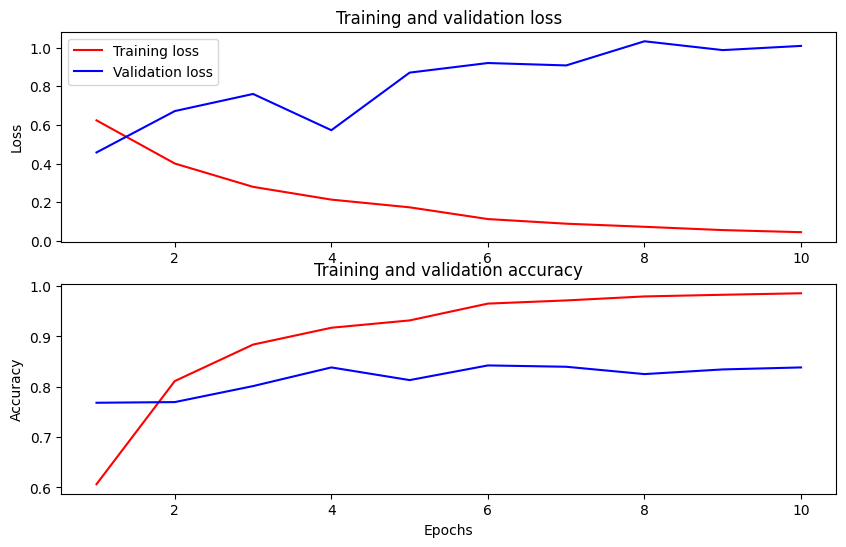

In [ ]:
pnw_history_dict = pnw_history.history
print(pnw_history_dict.keys())

pnw_acc = pnw_history_dict['binary_accuracy']
pnw_val_acc = pnw_history_dict['val_binary_accuracy']
pnw_loss = pnw_history_dict['loss']
pnw_val_loss = pnw_history_dict['val_loss']

pnw_epochs = range(1, len(pnw_acc) + 1)
pnw_fig = plt.figure(figsize=(10, 6))
pnw_fig.tight_layout()

plt.subplot(2, 1, 1)

plt.plot(pnw_epochs, pnw_loss, 'r', label='Training loss')

plt.plot(pnw_epochs, pnw_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(pnw_epochs, pnw_acc, 'r', label='Training acc')
plt.plot(pnw_epochs, pnw_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Make Predictions

In [ ]:
# pnw_eval_data = np.concatenate([atn_array(100), mnh_array(100)], 0)
pnw_df = pd.DataFrame(np.squeeze(pnw_classifier_model.predict(eval_data)), columns=['Pos & Neg Word List Model'])
pnw_df.insert(1, "Title", eval_data, True)
pnw_df

7/7 [==============================] - 3s 334ms/step


,Pos & Neg Word List Model,Title
0,-4.871751,Girl Scouts refuse gift with transgender limits
1,8.266789,American to launch Dreamliner 787 service
2,6.145327,15 Times Celebrities Envisioned Violence Again...
3,-4.167357,Deadly Northern California Wildfire Spreads - ...
4,-4.333350,How Millennials Became Spooked by Credit Cards...
...,...,...
195,8.317531,moutiaa el zahed gives the islamic state salute
196,2.237307,afp defends raiding abc office annika smethurs...
197,5.051312,interview david williams
198,6.351323,top sprint cyclists put through paces ahead of...


### Compare predictions with the other models

In [ ]:
overall_df.insert(0, "Pos & Neg Word List", pnw_df['Pos & Neg Word List Model'])
overall_df

,Pos & Neg Word List,IMDb Model,FPB Model,Title
0,-4.871751,-0.733837,-5.805300,Girl Scouts refuse gift with transgender limits
1,8.266789,1.946372,4.798319,American to launch Dreamliner 787 service
2,6.145327,-0.163686,-4.357934,15 Times Celebrities Envisioned Violence Again...
3,-4.167357,0.435629,-3.547501,Deadly Northern California Wildfire Spreads - ...
4,-4.333350,2.373650,-3.737055,How Millennials Became Spooked by Credit Cards...
...,...,...,...,...
195,8.317531,3.655803,0.817480,moutiaa el zahed gives the islamic state salute
196,2.237307,-0.399266,-4.373072,afp defends raiding abc office annika smethurs...
197,5.051312,2.530798,0.933000,interview david williams
198,6.351323,3.797237,1.491438,top sprint cyclists put through paces ahead of...


## Model IV - News Sentiment Dataset

### Downloading the Dataset

In [ ]:
!cp "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/data/news_sentiment_dataset.csv" "/content/news_sentiment_dataset.csv"

In [ ]:
nsd_dataframe = pd.read_csv('news_sentiment_dataset.csv', encoding = 'utf-8', encoding_errors = 'ignore')
nsd_dataframe

,news_title,reddit_title,sentiment,text,url
0,Mark Cuban launches generic drug company,Billionaire Mark Cuban just launched a drug co...,1.0,Billionaire investor and Shark Tank star Mark ...,https://www.beckershospitalreview.com/pharmacy...
1,From Defendant to Defender: One Wrongfully Con...,"Man falsely imprisoned for 10 years, uses pris...",1.0,Attorney Jarrett Adams recently helped overtur...,https://www.nbcnews.com/news/us-news/defendant...
2,"Amazon Tribe Wins Lawsuit Against Big Oil, Sav...",Amazon tribe wins legal battle against oil com...,1.0,The Amazon Rainforest is well known across the...,https://www.disclose.tv/amazon-tribe-wins-laws...
3,Newark police: No officer fired a single shot ...,Newark police: No officer fired a single shot ...,1.0,Newark police: No officer fired a single shot ...,https://newjersey.news12.com/newark-police-no-...
4,Ingen barn døde i trafikken i 2019,No children died in traffic accidents in Norwa...,1.0,I 1970 døde det 560 mennesker i den norske tra...,https://www.nrk.no/trondelag/ingen-barn-dode-i...
...,...,...,...,...,...
843,Dee Why attack: Man allegedly choked and threa...,Dee Why attack: Man allegedly choked and threa...,0.0,Frightening details have emerged about a toile...,https://www.9news.com.au/2018/11/30/17/55/sydn...
844,Africa: Children and HIV/Aids - 'We Need to Ta...,Africa: Children and HIV/Aids - 'We Need to Ta...,0.0,"interview\n\nJohannesburg — 360,000 adolescent...",https://allafrica.com/stories/201811300567.html
845,Terrorism suspected in Eilat attack,Terrorism suspected in Eilat attack,0.0,A violent attack in the southern Israeli port ...,http://www.israelnationalnews.com/News/News.as...
846,Anti-Semitism never disappeared in Europe. It'...,Anti-Semitism never disappeared in Europe. It'...,0.0,"It's a 17-year-old boy, too frightened to wear...",https://edition.cnn.com/2018/11/27/europe/anti...


### Split the data into Training, Testing and Validation Datasets

In [ ]:
!rm -rf news_sentiment_dataset

In [ ]:
nsd_dataset_dir = 'news_sentiment_dataset'

os.mkdir(nsd_dataset_dir)

nsd_train_dir = os.path.join(nsd_dataset_dir, 'train')
nsd_test_dir = os.path.join(nsd_dataset_dir, 'test')

os.mkdir(nsd_train_dir)
os.mkdir(nsd_test_dir)

for path in [nsd_train_dir, nsd_test_dir]:
  os.mkdir(os.path.join(path, 'negative'))
  os.mkdir(os.path.join(path, 'positive'))


count_train = 1
count_test = 1

# Training Dataset
for ind in nsd_dataframe[int(.6*len(nsd_dataframe)):].index:
  with open(os.path.join(nsd_train_dir, 'negative' if nsd_dataframe['sentiment'][ind] == 0 else 'positive', str(count_train)+'.txt'), 'w') as file_obj:
    file_obj.write(nsd_dataframe['news_title'][ind])
  count_train +=1

# Testing Dataset
for ind in nsd_dataframe[:int(.3*len(nsd_dataframe))].index:
  with open(os.path.join(nsd_test_dir, 'negative' if nsd_dataframe['sentiment'][ind] == 0 else 'positive', str(count_test)+'.txt'), 'w') as file_obj:
    file_obj.write(nsd_dataframe['news_title'][ind])
  count_test +=1

### Preprocess Data

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

nsd_raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    nsd_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

nsd_class_names = nsd_raw_train_ds.class_names
nsd_train_ds = nsd_raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

nsd_val_ds = tf.keras.utils.text_dataset_from_directory(
    nsd_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

nsd_val_ds = nsd_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

nsd_test_ds = tf.keras.utils.text_dataset_from_directory(
    nsd_test_dir,
    batch_size=batch_size)

nsd_test_ds = nsd_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 340 files belonging to 2 classes.
Using 272 files for training.
Found 340 files belonging to 2 classes.
Using 68 files for validation.
Found 254 files belonging to 2 classes.


### Selecting a BERT Model

In [ ]:
#@title Choose a BERT model to fine-tune for Positive and Negative Word List Model

nsd_bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]


nsd_tfhub_handle_encoder = map_name_to_handle[nsd_bert_model_name]
nsd_tfhub_handle_preprocess = map_model_to_preprocess[nsd_bert_model_name]

print(f'BERT model selected           : {nsd_tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {nsd_tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
nsd_bert_preprocess_model = hub.KerasLayer(nsd_tfhub_handle_preprocess)

In [ ]:
nsd_bert_model = hub.KerasLayer(nsd_tfhub_handle_encoder)

### Using the BERT Model

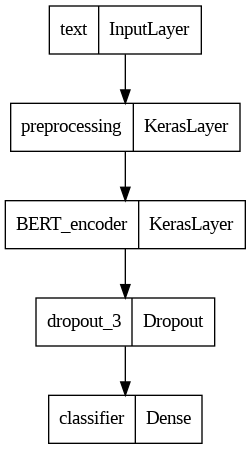

In [ ]:
nsd_classifier_model = build_classifier_model(nsd_tfhub_handle_preprocess, nsd_tfhub_handle_encoder)
tf.keras.utils.plot_model(nsd_classifier_model)

In [ ]:
nsd_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
nsd_metrics = tf.metrics.BinaryAccuracy()

nsd_epochs = 10
nsd_steps_per_epoch = tf.data.experimental.cardinality(nsd_train_ds).numpy()
nsd_num_train_steps = nsd_steps_per_epoch * nsd_epochs
nsd_num_warmup_steps = int(0.1*nsd_num_train_steps)

nsd_init_lr = 3e-5
nsd_optimizer = optimization.create_optimizer(init_lr=nsd_init_lr,
                                          num_train_steps=nsd_num_train_steps,
                                          num_warmup_steps=nsd_num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
nsd_classifier_model.compile(optimizer=nsd_optimizer,
                         loss=nsd_loss,
                         metrics=nsd_metrics)

nsd_history = nsd_classifier_model.fit(x=nsd_train_ds,
                               validation_data=nsd_val_ds,
                               epochs=nsd_epochs)

Epoch 1/10
9/9 [==============================] - 11s 359ms/step - loss: 0.9258 - binary_accuracy: 0.3529 - val_loss: 0.6171 - val_binary_accuracy: 0.7206
Epoch 2/10
9/9 [==============================] - 2s 230ms/step - loss: 0.6262 - binary_accuracy: 0.7096 - val_loss: 0.5630 - val_binary_accuracy: 0.7500
Epoch 3/10
9/9 [==============================] - 2s 233ms/step - loss: 0.5100 - binary_accuracy: 0.7684 - val_loss: 0.5127 - val_binary_accuracy: 0.6471
Epoch 4/10
9/9 [==============================] - 2s 234ms/step - loss: 0.4575 - binary_accuracy: 0.8015 - val_loss: 0.4607 - val_binary_accuracy: 0.8088
Epoch 5/10
9/9 [==============================] - 2s 258ms/step - loss: 0.3995 - binary_accuracy: 0.8309 - val_loss: 0.4282 - val_binary_accuracy: 0.8235
Epoch 6/10
9/9 [==============================] - 3s 303ms/step - loss: 0.3363 - binary_accuracy: 0.8566 - val_loss: 0.4171 - val_binary_accuracy: 0.8088
Epoch 7/10
9/9 [==============================] - 2s 231ms/step - loss: 0.2

### Evaluating the Model

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


Text(0, 0.5, 'Accuracy')

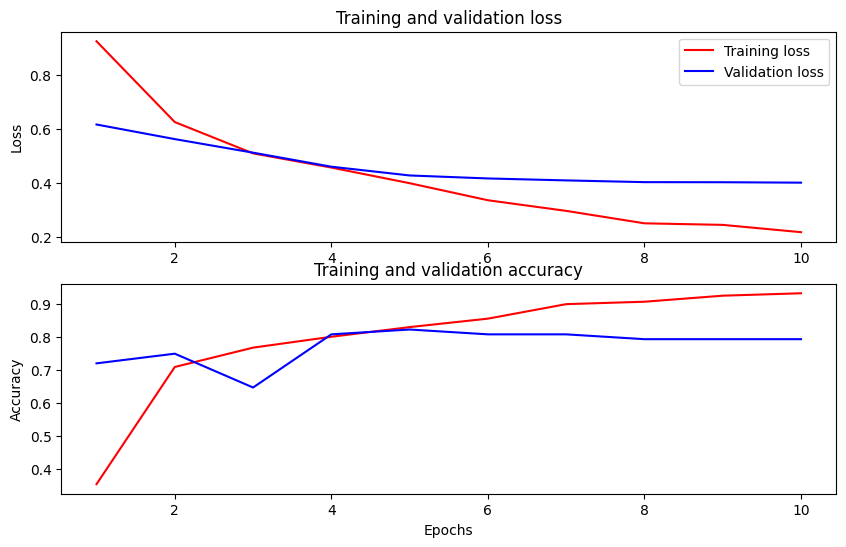

In [ ]:
nsd_history_dict = nsd_history.history
print(nsd_history_dict.keys())

nsd_acc = nsd_history_dict['binary_accuracy']
nsd_val_acc = nsd_history_dict['val_binary_accuracy']
nsd_loss = nsd_history_dict['loss']
nsd_val_loss = nsd_history_dict['val_loss']

nsd_epochs = range(1, len(nsd_acc) + 1)
nsd_fig = plt.figure(figsize=(10, 6))
nsd_fig.tight_layout()

plt.subplot(2, 1, 1)

plt.plot(nsd_epochs, nsd_loss, 'r', label='Training loss')

plt.plot(nsd_epochs, nsd_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(nsd_epochs, nsd_acc, 'r', label='Training acc')
plt.plot(nsd_epochs, nsd_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

### Make Predictions

In [ ]:
# nsd_eval_data = np.concatenate([atn_array(100), mnh_array(100)], 0)
nsd_df = pd.DataFrame(np.squeeze(nsd_classifier_model.predict(eval_data)), columns=['News Sentiment Dataset Model'])
nsd_df.insert(1, "Title", eval_data, True)
nsd_df

7/7 [==============================] - 2s 141ms/step


,News Sentiment Dataset Model,Title
0,2.802962,Girl Scouts refuse gift with transgender limits
1,2.521557,American to launch Dreamliner 787 service
2,-0.927634,15 Times Celebrities Envisioned Violence Again...
3,0.693936,Deadly Northern California Wildfire Spreads - ...
4,1.577643,How Millennials Became Spooked by Credit Cards...
...,...,...
195,0.816248,moutiaa el zahed gives the islamic state salute
196,1.522570,afp defends raiding abc office annika smethurs...
197,-0.127026,interview david williams
198,1.289493,top sprint cyclists put through paces ahead of...


### Compare predictions with the other models

In [ ]:
overall_df.insert(0, "News Sentiment Dataset Model", nsd_df['News Sentiment Dataset Model'])
overall_df

,News Sentiment Dataset Model,Pos & Neg Word List,IMDb Model,FPB Model,Title
0,2.802962,-4.871751,-0.733837,-5.805300,Girl Scouts refuse gift with transgender limits
1,2.521557,8.266789,1.946372,4.798319,American to launch Dreamliner 787 service
2,-0.927634,6.145327,-0.163686,-4.357934,15 Times Celebrities Envisioned Violence Again...
3,0.693936,-4.167357,0.435629,-3.547501,Deadly Northern California Wildfire Spreads - ...
4,1.577643,-4.333350,2.373650,-3.737055,How Millennials Became Spooked by Credit Cards...
...,...,...,...,...,...
195,0.816248,8.317531,3.655803,0.817480,moutiaa el zahed gives the islamic state salute
196,1.522570,2.237307,-0.399266,-4.373072,afp defends raiding abc office annika smethurs...
197,-0.127026,5.051312,2.530798,0.933000,interview david williams
198,1.289493,6.351323,3.797237,1.491438,top sprint cyclists put through paces ahead of...


## Save All Models for later use

In [ ]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [ ]:
imdb_classifier_model.save('models/imdb_classifier_model', include_optimizer=False)
fpb_classifier_model.save('models/fpb_classifier_model', include_optimizer=False)
pnw_classifier_model.save('models/pnw_classifier_model', include_optimizer=False)
nsd_classifier_model.save('models/nsd_classifier_model', include_optimizer=False)

In [ ]:
!cp -R "models/imdb_classifier_model" "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/models/imdb_classifier_model"
!cp -R "models/fpb_classifier_model" "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/models/fpb_classifier_model"
!cp -R "models/pnw_classifier_model" "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/models/pnw_classifier_model"
!cp -R "models/nsd_classifier_model" "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/models/nsd_classifier_model"

## Load Previously Built Models

In [3]:
!rm -rf models
!mkdir models

In [4]:
# Copy models from Google Drive
# !cp -R "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/models/imdb_classifier_model" "models/imdb_classifier_model"
# !cp -R "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/models/fpb_classifier_model" "models/fpb_classifier_model"
!cp -R "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/models/pnw_classifier_model" "models/pnw_classifier_model"
# !cp -R "/content/drive/MyDrive/Colab Notebooks/Daily Sunshine App/models/nsd_classifier_model" "models/nsd_classifier_model"

In [5]:
# imdb_model = tf.saved_model.load('models/imdb_classifier_model')
# fpb_model = tf.saved_model.load('models/fpb_classifier_model')
pnw_model = tf.saved_model.load('models/pnw_classifier_model')
# nsd_model = tf.saved_model.load('models/nsd_classifier_model')

## Creating a Script for connecting to NewsAPI.org API

In [6]:
!pip install newsapi-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
#@title API KEY { display-mode: "form" }

API_KEY = 'a476e6c66455446f8251b87a2e598384' #@param {type:"string"}

In [8]:
from newsapi import NewsApiClient
newsapi = NewsApiClient(api_key=API_KEY)

### `Everything` endpoint

It is necessary to enter a search query for this endpoint to work as the data returned by it is quite vast. If this value is not provided, then NewsAPI returns an error.

In [9]:
#@title Search Query Parameters { display-mode: "form" }
#@markdown Enter a list of keywords that should be used for fetching the articles <br> The input must be in the form of a python list of strings i.e. <br> ***\['apple', 'banana', 'carrot', 'dates'\]***
keywords = ['ai', 'health', 'environment', 'life', 'pet', 'finance', 'growth'] #@param {type:"raw"}

#@markdown Enter a date that the oldest article in the results can have <br> Default is 'current day'
from_date = "2023-05-28" #@param {type:"date"}

In [10]:
# Run a loop for all keywords
all_articles = []

for query in keywords:
  print('Currently searching for articles with the keyword', query)
  query_articles = newsapi.get_everything(q=query,
                                      from_param=from_date,
                                      language='en',
                                      )
  if query_articles['totalResults'] > 100:
    for i in range((query_articles['totalResults'] // 100)-2):
      if (i > 20) :
        break
      try:
        next_query_articles = newsapi.get_everything(q=query,
                                          from_param=from_date,
                                          language='en',
                                          page = i+2
                                          )
        
        query_articles['articles'] += next_query_articles['articles']
      except:
        break

  print('Articles collected -', len(query_articles['articles']))
  all_articles += query_articles['articles']

print('\nTotal number of articles collected -', len(all_articles))

Currently searching for articles with the keyword ai
Articles collected - 500
Currently searching for articles with the keyword health
Articles collected - 500
Currently searching for articles with the keyword environment
Articles collected - 500
Currently searching for articles with the keyword life
Articles collected - 500
Currently searching for articles with the keyword pet
Articles collected - 96
Currently searching for articles with the keyword finance
Articles collected - 400
Currently searching for articles with the keyword growth
Articles collected - 500

Total number of articles collected - 2996


In [23]:
# Create a Dataframe of articles
import pandas as pd

everything_df = pd.DataFrame(all_articles)
everything_df.drop_duplicates(subset="title", keep=False, inplace=True)

### Run Predictions on the titles



In [24]:
everything_df['PosNeg Score'] = 0
for i in range(len(everything_df) // 100):
  print('Iteration', i+1, 'of', len(everything_df) // 100)
  everything_df.iloc[i*100:(i+1)*100, 8] = np.squeeze(pnw_model(everything_df[i*100:(i+1)*100]['title']))

if not len(everything_df) % 100 == 0:
  everything_df.iloc[-(len(everything_df) % 100):, 8] = np.squeeze(pnw_model(everything_df[-(len(everything_df) % 100):]['title']))

Iteration 1 of 19
Iteration 2 of 19
Iteration 3 of 19
Iteration 4 of 19
Iteration 5 of 19
Iteration 6 of 19
Iteration 7 of 19
Iteration 8 of 19
Iteration 9 of 19
Iteration 10 of 19
Iteration 11 of 19
Iteration 12 of 19
Iteration 13 of 19
Iteration 14 of 19
Iteration 15 of 19
Iteration 16 of 19
Iteration 17 of 19
Iteration 18 of 19
Iteration 19 of 19


In [25]:
everything_df.insert(9, "PosNeg Confidence", tf.sigmoid(everything_df['PosNeg Score']), True)
everything_df

,source,author,title,description,url,urlToImage,publishedAt,content,PosNeg Score,PosNeg Confidence
0,"{'id': 'business-insider', 'name': 'Business I...","Jyoti Mann,Beatrice Nolan",The music industry is freaking out about AI — ...,"""patten"" made his album ""Mirage FM"" entirely f...",https://www.businessinsider.com/music-industry...,https://i.insider.com/646e42256f9a4800187369fb...,2023-05-28T09:08:54Z,"""Patten,"" aka Damien Roach.Damien Roach\r\n<ul...",7.800910,0.999591
1,"{'id': None, 'name': 'Hackaday'}",Al Williams,AI Creates Killer Drug,Researchers in Canada and the United States ha...,https://hackaday.com/2023/05/28/ai-creates-kil...,https://hackaday.com/wp-content/uploads/2023/0...,2023-05-28T14:00:58Z,Researchers in Canada and the United States ha...,6.062581,0.997677
2,"{'id': None, 'name': 'Hackaday'}",Donald Papp,AI Image Generation Gets a Drag Interface,AI image generators have gained new tools and ...,https://hackaday.com/2023/05/27/ai-image-gener...,https://hackaday.com/wp-content/uploads/2023/0...,2023-05-28T02:00:12Z,AI image generators have gained new tools and ...,9.189483,0.999898
6,"{'id': None, 'name': 'VentureBeat'}","Suhail Nimji, Jasper, Saad Ansari, Jasper",How generative AI can revolutionize customizat...,It's time to look beyond using generative AI t...,https://venturebeat.com/ai/how-generative-ai-c...,https://venturebeat.com/wp-content/uploads/202...,2023-05-28T16:10:00Z,Join top executives in San Francisco on July 1...,9.536411,0.999928
9,"{'id': None, 'name': 'VentureBeat'}",Victor Dey,Nvidia CEO reveals groundbreaking generative A...,Huang believes the innovations will facilitate...,https://venturebeat.com/ai/nvidia-ceo-reveals-...,https://venturebeat.com/wp-content/uploads/202...,2023-05-29T04:00:00Z,Join top executives in San Francisco on July 1...,9.233106,0.999902
...,...,...,...,...,...,...,...,...,...,...
2987,"{'id': None, 'name': 'Vulture'}",Maggie Fremont,"Somebody, Somewhere Recap: The Fred Rococo Bac...",While things seem dire between Sam and Joel at...,http://www.vulture.com/article/somebody-somewh...,https://pyxis.nymag.com/v1/imgs/b2c/e2a/2bda83...,2023-05-29T03:33:51Z,"Well, rip our hearts out and stomp on them why...",7.451091,0.999420
2988,"{'id': None, 'name': 'Vulture'}",Maggie Fremont,Somebody Somewhere Season-Finale Recap: A Craz...,A catharsis and joy-filled finale brings Sam a...,http://www.vulture.com/article/somebody-somewh...,https://pyxis.nymag.com/v1/imgs/8b7/cc7/b89cc8...,2023-05-29T04:05:34Z,Is there any show that knows how to do joy bet...,7.213947,0.999264
2989,"{'id': None, 'name': 'Bitrebels.com'}",Marc Solano,3 Best Websites To Buy TikTok Followers (Activ...,Do you need assistance in increasing your TikT...,https://bitrebels.com/social/3-best-websites-b...,https://bitrebels.com/wp-content/uploads/2023/...,2023-05-28T22:00:00Z,Do you need assistance in increasing your TikT...,9.029008,0.999880
2990,"{'id': None, 'name': 'Forbes'}","Jordan Thomas, Forbes Staff, \n Jordan Thomas,...",These Are The Best Memorial Day Sales This Year,"To ensure you don’t miss any of the deals, we’...",https://www.forbes.com/sites/forbes-personal-s...,https://imageio.forbes.com/specials-images/ima...,2023-05-28T23:46:19Z,Whether youve been meaning to pick up a new ma...,8.470292,0.999790


In [22]:
# Export for futher inference

excel_writer = pd.ExcelWriter('Everything.xlsx')

everything_df.to_excel(excel_writer)
  
excel_writer.save()

<ipython-input-22-c1ebd7fc0934>:7: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  excel_writer.save()
